In [1]:
!git clone https://github.com/KAIST-Visual-AI-Group/GrounDiT

Cloning into 'GrounDiT'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 55 (delta 13), reused 23 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 3.53 MiB | 19.55 MiB/s, done.
Resolving deltas: 100% (13/13), done.


### Demo notebook for GrounDiT

In [2]:
!ls

GrounDiT  sample_data


In [3]:
%cd GrounDiT

/content/GrounDiT


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [6]:
import os
import json
from functools import partial
from tqdm import tqdm
import torch
from diffusers.utils.torch_utils import randn_tensor

from groundit.pipeline_groundit import ASPECT_RATIO_512_BIN
from groundit.utils import *

device = torch.device("cuda:0")

### Load GrounDiT model (based on PixArt-$\alpha$)

In [7]:
# Set model configs
hw_bin = ASPECT_RATIO_512_BIN
model_id = "PixArt-alpha/PixArt-XL-2-512x512"

# Load GrounDiT model
pipe, tokenizer = load_groundit_model(model_id, device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.87G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/4.19G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/907 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/2.45G [00:00<?, ?B/s]

Some weights of the model checkpoint at PixArt-alpha/PixArt-XL-2-512x512 were not used when initializing Transformer2DModel: 
 ['caption_projection.y_embedding']


### Set text prompt and bounding box conditions

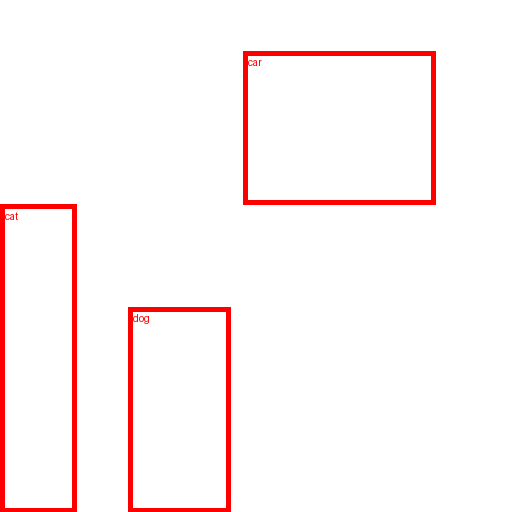

In [20]:
# Text and bounding box conditions for GrounDiT
# NOTE: Change the prompt and phrases to generate different images!
data = {
    "prompt": "a cat and dog. A car is located to the left of them.",
    "phrases": ["cat", "dog", "car"],
    "bboxes": [[[0.0, 0.4, 0.15, 1.0]], [[0.25, 0.6, 0.45, 1.0]], [[0.475, 0.1, 0.85, 0.4]]],
    "height": 512,
    "width": 512
}

# Set seed
seed = 2343

# Visualize bounding boxes
bbox_image = Image.new("RGB", (data["width"], data["height"]), (255, 255, 255))
draw_box(
    bbox_image, data["bboxes"], ";".join(data["phrases"]),
    height=data["height"], width=data["width"]
)
bbox_image

### Generate image with GrounDiT!

  0%|          | 0/50 [00:00<?, ?it/s]

moo
tensor(0.0269, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
moo
tensor(0.0267, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
moo
tensor(0.0269, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
test code change2
moo
tensor(0.0268, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
moo
tensor(0.0264, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
moo
tensor(0.0268, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
test code change2
moo
tensor(0.0264, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
moo
tensor(0.0265, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
moo
tensor(0.0265, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
test code change2
moo
tensor(0.0263, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
moo
tensor(0.0264, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
moo
tensor(0.0266, device='cuda:0', dtype=torch.float16

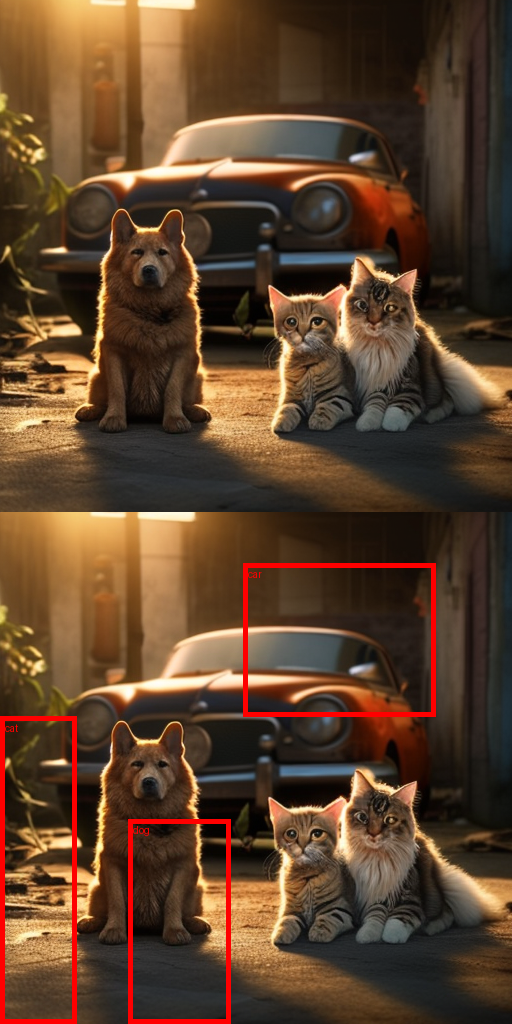

In [21]:
prompt = data["prompt"]
phrases = data["phrases"]
bboxes = data["bboxes"]

bbox_list = sanity_check(bboxes, phrases)

# Find the location of phrase indices in the prompt after tokenization, do it for all pharse in phrases list.
phrases_idx = get_phrases_idx_in_prompt(prompt, phrases, tokenizer)

# Convert bbox coordinates to pixel & latent & patch space. Get the indices of the patches in the patch space that are covered by the bounding box.
# Here boundnig box region corresponds to "Local Patch" in the paper. See Figure 2.
if 'height' in data and 'width' in data:
    original_height, original_width = data['height'], data['width']
    target_height, target_width = pipe.classify_height_width_bin(original_height, original_width, hw_bin)
elif 'aspect_ratio' in data:
    target_height, target_width = pipe.classify_aspect_ratio_bin(data['aspect_ratio'], hw_bin)
    original_height, original_width = target_height, target_width
else:
    raise ValueError("Invalid data format. Need to provide either height/width or aspect_ratio.")

# Set bbox coordinates in pixel space and latent space
latent_height, latent_width = target_height // pipe.vae_scale_factor, target_width // pipe.vae_scale_factor
all_bbox_coord_in_pixel_space = get_bbox_coord_in_pixel_space(bbox_list, target_height, target_width)
all_bbox_coord_in_latent_space = get_bbox_coord_in_latent_space(bbox_list, latent_height, latent_width)

# Get the "Object Image" height and width in pixel space, where "Object Image" is introduced in the paper. See Figure 2.
object_image_hw_in_pixel_space = get_bbox_region_hw(all_bbox_coord_in_pixel_space, hw_bin_classify_func=partial(pipe.classify_height_width_bin, ratios=hw_bin))

# Set seed
seed_everything(seed)
generator = torch.Generator(device=device).manual_seed(seed)

# Main image latent
latent_shape = (1, 4, latent_height, latent_width)
latent = randn_tensor(latent_shape, generator=generator, device=device, dtype=torch.float16) * pipe.scheduler.init_noise_sigma

# Object images latents
object_image_latents_list = list()
for object_image_hw_list in object_image_hw_in_pixel_space:
    object_image_latents_list_for_each_phrase = list()
    for object_image_hw in object_image_hw_list:
        object_image_latents_shape = (1, 4, object_image_hw[0] // pipe.vae_scale_factor, object_image_hw[1] // pipe.vae_scale_factor)
        object_image_latents = randn_tensor(object_image_latents_shape, generator=generator, device=device, dtype=torch.float16) * pipe.scheduler.init_noise_sigma
        object_image_latents_list_for_each_phrase.append(object_image_latents)

    object_image_latents_list.append(object_image_latents_list_for_each_phrase)

# Generate sample
image = pipe(
    prompt=prompt,
    width=original_width,
    height=original_height,
    latents=latent,
    # General Arguments
    bbox_list=bbox_list,
    phrases=phrases,
    phrases_idx=phrases_idx,
    # Local Update Config
    object_image_latents_list=object_image_latents_list,
    object_image_hw_in_pixel_space=object_image_hw_in_pixel_space,
    all_bbox_coord_in_latent_space=all_bbox_coord_in_latent_space
)[0][0]

# Save the generated samples
image_with_bbox = image.copy()
draw_box(
    image_with_bbox, bbox_list, ";".join(phrases),
    original_height, original_width
)

# Concat
concat_image = image_grid([image, image_with_bbox], 2, 1)
concat_image